In [2]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from utils import remove_all_ticks_and_labels
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

device = 'cpu'

[None, (-3.0, 3.0), (-3.0, 3.0)]

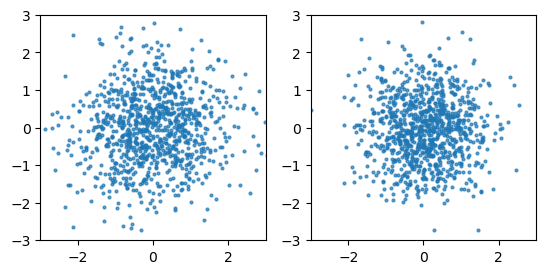

In [3]:
from prior_utils import diffused_sample
from dataset_utils import generate_2d_swiss_roll
gt_manifold = generate_2d_swiss_roll(int(1e3), True, return_as_tensor=True)[1]

num_steps = 2000
diffused_x_2000 = diffused_sample(num_steps, num_steps-1, gt_manifold)

num_steps = 100
diffused_x_100 = diffused_sample(num_steps, num_steps-1, gt_manifold)

fig, ax = plt.subplots(1, 2)
ax[0].scatter(*diffused_x_2000.T, s=4, alpha=0.7)
ax[0].set(aspect='equal', xlim=[-3, 3], ylim=[-3, 3])
ax[1].scatter(*diffused_x_100.T, s=4, alpha=0.7)
ax[1].set(aspect='equal', xlim=[-3, 3], ylim=[-3, 3])

In [4]:
# load dataset
from dataset_utils import generate_2d_swiss_roll

# load model
from utils import select_model
# model, num_steps, ambient_dims = select_model('unconditional-dendritic', 67)
# model, num_steps, ambient_dims = select_model('unconditional-concat', 17)
model, num_steps, ambient_dims = select_model('unconditional-dendritic-4-layers', 5)
print(num_steps)

# --------------- sample from the prior using neural forward and reverse processes -------------- #
from prior_utils import sequential_prior_sampler, p_sample_loop

sample_size = int(5e2)
x_rev = p_sample_loop(model, (sample_size, ambient_dims), num_steps, device, normalized_beta_schedule=False)
print(x_rev.shape)

model loaded!
2000
torch.Size([2001, 500, 2])


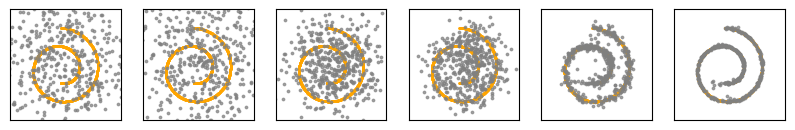

In [5]:
# intermediate steps during the forward/reverse processes
temps = [0, 1000, 1500, 1800, 1950, 2000]
lim = 1.5
lims = [-lim, lim]

fig, ax = plt.subplots(1, len(temps), figsize=(10,2))
for i, t in enumerate(temps):
    ax[i].scatter(*gt_manifold.T, s=1, color='orange')
    ax[i].scatter(*x_rev[t].T, s=3, alpha=0.7, color='grey')
    
for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)
    

# regenerate figure 2E using the 2000 step model

we want to see if a model with finer discretization will have lower KL divergence between samples that were generated using a value of $g_t$ evaluated at x_t vs mu. 

In [19]:
# load data
import zarr
data_base_dir = os.path.join(base_dir, 'core', 'saved_arrays', 'samples')
model_name = 'unconditional-dendritic-4-layers'
model_num = 5
data_dir = os.path.join(data_base_dir, f'{model_name}_{model_num}')

# load iid samples
iid_mu_dir = os.path.join(data_dir, 'posterior-iid-unimodal-bu-mu', 'num_samples=1e+03-num_runs=1e+02-batch_idx=0')
iid_xt_dir = os.path.join(data_dir, 'posterior-iid-unimodal-bu-xt', 'num_samples=1e+03-num_runs=1e+02-batch_idx=0')
samples_iid_mus = []; samples_iid_xts = []
for j in range(10):
    samples_iid_mu = []; samples_iid_xt = []
    for i in range(5):
        iid_mu = zarr.load(os.path.join(iid_mu_dir, f'x_rev-run_num={5*j + i}.zarr'))
        iid_xt = zarr.load(os.path.join(iid_xt_dir, f'x_rev-run_num={5*j + i}.zarr'))
        samples_iid_mu.append(iid_mu)
        samples_iid_xt.append(iid_xt)
    samples_iid_mu = np.concatenate(samples_iid_mu, axis=1)
    samples_iid_xt = np.concatenate(samples_iid_xt, axis=1)
    samples_iid_mus.append(samples_iid_mu)
    samples_iid_xts.append(samples_iid_xt)
samples_iid_mus = np.stack(samples_iid_mus)
samples_iid_xts = np.stack(samples_iid_xts)

print(samples_iid_mus.shape)

(10, 2001, 5000, 2)


In [21]:
# load seq samples
samples_seq_mus = []; samples_seq_xts = []
for i in range(10):  # 10
    seq_mu_dir = os.path.join(data_dir, 'posterior-seq-unimodal-bu-mu', f'num_samples=5e+03-num_runs=1-batch_idx={i}')
    seq_xt_dir = os.path.join(data_dir, 'posterior-seq-unimodal-bu-xt', f'num_samples=5e+03-num_runs=1-batch_idx={i}')
    samples_seq_mu = zarr.load(os.path.join(seq_mu_dir, 'x_rev-run_num=0.zarr'))
    samples_seq_xt = zarr.load(os.path.join(seq_xt_dir, 'x_rev-run_num=0.zarr'))
    samples_seq_mus.append(samples_seq_mu)
    samples_seq_xts.append(samples_seq_xt)
samples_seq_mus = np.stack(samples_seq_mus)
samples_seq_xts = np.stack(samples_seq_xts)

print(samples_seq_mus.shape)

(10, 5000, 2001, 2)


In [22]:
# save data
mode == 'load'

save_dir = os.path.join(base_dir, 'core', 'saved_arrays', 'eval_loc', 'fine_discretization', 'sample_size=5000-num_runs=10')
if mode == 'save':
    zarr.save(os.path.join(save_dir, 'iid_mus'), samples_iid_mus)
    zarr.save(os.path.join(save_dir, 'iid_xts'), samples_iid_xts)
    zarr.save(os.path.join(save_dir, 'seq_mus'), samples_seq_mus)
    zarr.save(os.path.join(save_dir, 'seq_xts'), samples_seq_xts)
elif mode == 'load':
    break

In [66]:
# now calculate the histogram of samples from the amortized posterior for all thetas
from likelihood_utils import calculate_histogram_for_seq_data, calculate_histogram_for_iid_data

num_bins_per_dim = 10
domain_range = 2

num_runs = 10

histograms_iid_xts = []
histograms_iid_mus = []
histograms_seq_xts = []
histograms_seq_mus = []

for i in range(num_runs):
    # iid
    histograms_iid_xt = calculate_histogram_for_iid_data(samples_iid_xts[i], num_bins_per_dim, domain_range)
    histograms_iid_mu = calculate_histogram_for_iid_data(samples_iid_mus[i], num_bins_per_dim, domain_range)

    # sequential
    histograms_seq_xt = calculate_histogram_for_seq_data(samples_seq_xts[i], num_bins_per_dim, domain_range)
    histograms_seq_mu = calculate_histogram_for_seq_data(samples_seq_mus[i], num_bins_per_dim, domain_range)

    histograms_iid_xts.append(histograms_iid_xt)
    histograms_iid_mus.append(histograms_iid_mu)
    histograms_seq_xts.append(histograms_seq_xt)
    histograms_seq_mus.append(histograms_seq_mu)

histograms_iid_xts = np.stack(histograms_iid_xts)
histograms_iid_mus = np.stack(histograms_iid_mus)
histograms_seq_xts = np.stack(histograms_seq_xts)
histograms_seq_mus = np.stack(histograms_seq_mus) 
print(histograms_iid_xts.shape)


from scipy.stats import entropy

# can't compute KL divergence when bins are empty, so a (biased) solution is to a small epsilon to each bin
epsilon = 1e-5  

entropies_iids = []
entropies_seqs = []

for i in range(num_runs):
    # ------------------------------------ iid ----------------------------------- #
    p = histograms_iid_mus[i] + epsilon  # xt distribution
    q = histograms_iid_xts[i] + epsilon  # mu distribution

    entropies_iid = []
    for phi in range(len(histograms_iid_mus[i])):
        p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
        q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
        entropies_iid.append(entropy(p_phi, q_phi))
    entropies_iid = np.stack(entropies_iid)
    entropies_iids.append(entropies_iid)


    # -------------------------------- sequential -------------------------------- #
    p = histograms_seq_mus[i] + epsilon  # xt distribution
    q = histograms_seq_xts[i] + epsilon  # mu distribution

    entropies_seq = []
    for phi in range(len(histograms_seq_mus[i])):
        p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
        q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
        entropies_seq.append(entropy(p_phi, q_phi))
    entropies_seq = np.stack(entropies_seq)
    entropies_seqs.append(entropies_seq)

entropies_iids = np.stack(entropies_iids)
entropies_seqs = np.stack(entropies_seqs)
print(entropies_iids.shape)

(10, 2001, 10, 10)
(10, 2001)


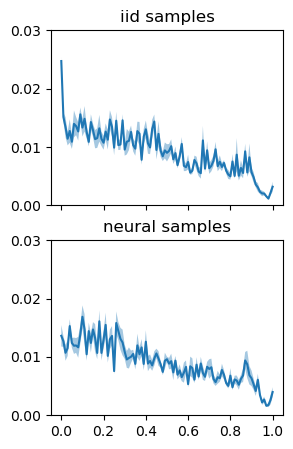

In [67]:
subsample = 20

mean_entropy_iid = np.mean(entropies_iids, axis=0)[::subsample]
mean_entropy_seq = np.mean(entropies_seqs, axis=0)[::subsample]
std_entropy_iid = np.std(entropies_iids, axis=0)[::subsample] /  np.sqrt(num_runs)
std_entropy_seq = np.std(entropies_seqs, axis=0)[::subsample] / np.sqrt(num_runs)

fig, ax = plt.subplots(2, 1, figsize=(3, 5), sharex=True)
ls = np.linspace(0, 1, len(mean_entropy_seq))
ax[0].plot(ls, mean_entropy_iid)
ax[0].fill_between(ls, mean_entropy_iid-std_entropy_iid, mean_entropy_iid+std_entropy_iid, alpha=0.4)
ax[0].set(title='iid samples')
# ax[0].set(ylim=[0, 0.2])

ax[1].plot(ls, mean_entropy_seq)
ax[1].fill_between(ls, mean_entropy_seq-std_entropy_seq, mean_entropy_seq+std_entropy_seq, alpha=0.4)
# ax[1].set(title='neural samples', ylabel='KL divergence', xlabel='$\\beta_t$')
ax[1].set(title='neural samples')
# ax[1].set(ylim=[0, 0.2])

for a in ax:
    a.set(ylim=[0, 0.03], yticks=[0, 0.01, 0.02, 0.03], xticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

from plot import save_fig
# save_fig(fig, 'figure2-evaluation-location-1e4-samples')

In [68]:
# compare against 5e3 samples from the 100 step model
data_dir = os.path.join(base_dir, 'core/saved_arrays/samples/', f'unconditional-dendritic-4-layers_1')
data_dir_iid_xt = os.path.join(data_dir, 'posterior-iid-unimodal-bu-xt', 'num_samples=1e+04-num_runs=1e+01-batch_idx=0')
data_dir_iid_mu = os.path.join(data_dir, 'posterior-iid-unimodal-bu-mu', 'num_samples=1e+04-num_runs=1e+01-batch_idx=0')
data_dir_seq_xt = os.path.join(data_dir, 'posterior-seq-unimodal-bu-xt', 'num_samples=1e+04-num_runs=1e+01-batch_idx=0')
data_dir_seq_mu = os.path.join(data_dir, 'posterior-seq-unimodal-bu-mu', 'num_samples=1e+04-num_runs=1e+01-batch_idx=0')

num_runs = 10
samples_iid_reverse_xt = []
samples_iid_reverse_mu = []
samples_seq_reverse_xt = []
samples_seq_reverse_mu = []
for run_idx in range(num_runs):
    samples_iid_xt = zarr.load(os.path.join(data_dir_iid_xt, f'x_rev-run_num={run_idx}.zarr'))
    samples_iid_mu = zarr.load(os.path.join(data_dir_iid_mu, f'x_rev-run_num={run_idx}.zarr'))
    samples_iid_reverse_xt.append(samples_iid_xt)
    samples_iid_reverse_mu.append(samples_iid_mu)

    samples_seq_xt = zarr.load(os.path.join(data_dir_seq_xt, f'x_rev-run_num={run_idx}.zarr'))
    samples_seq_mu = zarr.load(os.path.join(data_dir_seq_mu, f'x_rev-run_num={run_idx}.zarr'))
    samples_seq_reverse_xt.append(samples_seq_xt)
    samples_seq_reverse_mu.append(samples_seq_mu)

samples_iid_reverse_xt = np.array(samples_iid_reverse_xt)[:, :, :int(5e3)]
samples_iid_reverse_mu = np.array(samples_iid_reverse_mu)[:, :, :int(5e3)]
samples_seq_reverse_xt = np.array(samples_seq_reverse_xt)[:, :int(5e3)]
samples_seq_reverse_mu = np.array(samples_seq_reverse_mu)[:, :int(5e3)]

print(samples_iid_reverse_xt.shape)

# now calculate the histogram of samples from the amortized posterior for all thetas
from likelihood_utils import calculate_histogram_for_seq_data, calculate_histogram_for_iid_data


histograms_iid_xts_100 = []
histograms_iid_mus_100 = []
histograms_seq_xts_100 = []
histograms_seq_mus_100 = []

for i in range(num_runs):
    # iid
    histograms_iid_xt_100 = calculate_histogram_for_iid_data(samples_iid_reverse_xt[i], num_bins_per_dim, domain_range)
    histograms_iid_mu_100 = calculate_histogram_for_iid_data(samples_iid_reverse_mu[i], num_bins_per_dim, domain_range)

    # sequential
    histograms_seq_xt_100 = calculate_histogram_for_seq_data(samples_seq_reverse_xt[i], num_bins_per_dim, domain_range)
    histograms_seq_mu_100 = calculate_histogram_for_seq_data(samples_seq_reverse_mu[i], num_bins_per_dim, domain_range)

    histograms_iid_xts_100.append(histograms_iid_xt_100)
    histograms_iid_mus_100.append(histograms_iid_mu_100)
    histograms_seq_xts_100.append(histograms_seq_xt_100)
    histograms_seq_mus_100.append(histograms_seq_mu_100)

histograms_iid_xts_100 = np.stack(histograms_iid_xts_100)
histograms_iid_mus_100 = np.stack(histograms_iid_mus_100)
histograms_seq_xts_100 = np.stack(histograms_seq_xts_100)
histograms_seq_mus_100 = np.stack(histograms_seq_mus_100) 
print(histograms_iid_xts_100.shape)


from scipy.stats import entropy

# can't compute KL divergence when bins are empty, so a (biased) solution is to a small epsilon to each bin
epsilon = 1e-5  

entropies_iids_100 = []
entropies_seqs_100 = []

for i in range(num_runs):
    # ------------------------------------ iid ----------------------------------- #
    p = histograms_iid_mus_100[i] + epsilon  # xt distribution
    q = histograms_iid_xts_100[i] + epsilon  # mu distribution

    entropies_iid = []
    for phi in range(len(histograms_iid_mus_100[i])):
        p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
        q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
        entropies_iid.append(entropy(p_phi, q_phi))
    entropies_iid = np.stack(entropies_iid)
    entropies_iids_100.append(entropies_iid)


    # -------------------------------- sequential -------------------------------- #
    p = histograms_seq_mus_100[i] + epsilon  # xt distribution
    q = histograms_seq_xts_100[i] + epsilon  # mu distribution

    entropies_seq = []
    for phi in range(len(histograms_seq_mus_100[i])):
        p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
        q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
        entropies_seq.append(entropy(p_phi, q_phi))
    entropies_seq = np.stack(entropies_seq)
    entropies_seqs_100.append(entropies_seq)

entropies_iids_100 = np.stack(entropies_iids_100)
entropies_seqs_100 = np.stack(entropies_seqs_100)
print(entropies_iids_100.shape)

(10, 101, 5000, 2)
(10, 101, 10, 10)
(10, 101)


In [69]:
mean_entropy_iid_100 = np.mean(entropies_iids_100, axis=0)
mean_entropy_seq_100 = np.mean(entropies_seqs_100, axis=0)
std_entropy_iid_100 = np.std(entropies_iids_100, axis=0) /  np.sqrt(num_runs)
std_entropy_seq_100 = np.std(entropies_seqs_100, axis=0) / np.sqrt(num_runs)

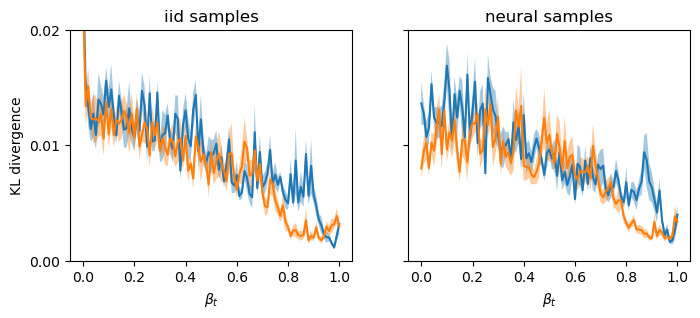

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
ax[0].plot(ls, mean_entropy_iid)
ax[0].plot(ls, mean_entropy_iid_100)
ax[0].fill_between(ls, mean_entropy_iid-std_entropy_iid, mean_entropy_iid+std_entropy_iid, alpha=0.4)
ax[0].fill_between(ls, mean_entropy_iid_100-std_entropy_iid_100, mean_entropy_iid_100+std_entropy_iid_100, alpha=0.4)
ax[0].set(title='iid samples')
ax[0].set(ylabel='KL divergence', xlabel='fraction of reverse process')
# ax[0].set(ylim=[0, 0.2])

ax[1].plot(ls, mean_entropy_seq)
ax[1].plot(ls, mean_entropy_seq_100)
ax[1].fill_between(ls, mean_entropy_seq-std_entropy_seq, mean_entropy_seq+std_entropy_seq, alpha=0.4)
ax[1].fill_between(ls, mean_entropy_seq_100-std_entropy_seq_100, mean_entropy_seq_100+std_entropy_seq_100, alpha=0.4)
ax[1].set(title='neural samples')
ax[1].set(xlabel='ascending phase')
# ax[1].set(ylim=[0, 0.2])

for a in ax:
    a.set(ylim=[0, 0.02], yticks=[0, 0.01, 0.02], xticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

from plot import save_fig
save_fig(fig, 'supp-discretization-samples5e3-domain2-bins100')